In [1]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import io 
import base64

In [2]:
app=FastAPI()

In [3]:
# Load Isolation Forest model
clf = joblib.load('isolation_forest.pkl')

# Load PCA model
pca = joblib.load('pca.pkl')

# Load Autoencoder model
from tensorflow.keras.models import load_model
autoencoder = load_model('my_mdl.h5',compile=False)


In [4]:
autoencoder.compile(optimizer='adam', loss='mse')

In [5]:
class InputData(BaseModel):
    timestamp:list
    temperature:list
    vibration:list
    pressure:list
    humidity:list
    machine_id:list

In [6]:
# Function to preprocess the data and generate the PCA plot
def preprocess_and_plot(df):
    # Drop columns not needed for the model
    required_features = [
        # List all features used during model training
        "temperature", "vibration", "pressure", "humidity",
        # Include any additional features like lag features, rolling stats, etc.
        # Example: "temp_lag_1", "vibration_mean_rolling", "hour_cos", etc.
    ]
    
    # Ensure the input data has the required features
    missing_features = set(required_features) - set(df.columns)
    if missing_features:
        raise ValueError(f"Input data is missing required features: {missing_features}")
    
    # Keep only the required features
    X_scaled = df[required_features]

    # Predict anomalies using Isolation Forest
    anomaly_predictions = clf.predict(X_scaled)
    anomaly_predictions = np.where(anomaly_predictions == -1, 1, 0)  # 1: Anomaly, 0: Normal

    # Transform data using PCA
    X_pca = pca.transform(X_scaled)

    # Create PCA plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=anomaly_predictions,
        cmap='coolwarm',
        edgecolor='k',
        s=20
    )
    plt.title("PCA Visualization of Anomalies")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label="Anomaly (1) or Normal (0)")

    # Save plot to BytesIO
    img_io = io.BytesIO()
    plt.savefig(img_io, format='png')
    img_io.seek(0)
    img_str = base64.b64encode(img_io.getvalue()).decode('utf-8')
    plt.close()

    return img_str


In [7]:
# Function to preprocess input data
def preprocess_input_data(df):
    # Ensure required columns are present
    required_columns = ["timestamp", "temperature", "vibration", "pressure", "humidity", "machine_id"]
    missing_columns = set(required_columns) - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing required columns in input data: {missing_columns}")
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Add lag features
    for lag in range(1, 4):
        df[f'temperature_lag_{lag}'] = df['temperature'].shift(lag).fillna(df['temperature'].iloc[0])
        df[f'vibration_lag_{lag}'] = df['vibration'].shift(lag).fillna(df['vibration'].iloc[0])
        df[f'pressure_lag_{lag}'] = df['pressure'].shift(lag).fillna(df['pressure'].iloc[0])
        df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag).fillna(df['humidity'].iloc[0])
    
    # Add rolling statistics (window size 3 used as an example)
    window_size = 3
    for col in ['temperature', 'vibration', 'pressure', 'humidity']:
        df[f'{col}_rolling_mean'] = df[col].rolling(window=window_size).mean().fillna(df[col])
        df[f'{col}_rolling_std'] = df[col].rolling(window=window_size).std().fillna(0)
        df[f'{col}_rolling_min'] = df[col].rolling(window=window_size).min().fillna(df[col])
        df[f'{col}_rolling_max'] = df[col].rolling(window=window_size).max().fillna(df[col])
        df[f'{col}_rolling_kurtosis'] = df[col].rolling(window=window_size).kurt().fillna(0)
        df[f'{col}_rolling_skew'] = df[col].rolling(window=window_size).skew().fillna(0)
    
    # Add time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Drop unnecessary columns (if needed)
    df.drop(columns=['timestamp', 'machine_id'], inplace=True, errors='ignore')
    
    return df

In [8]:
@app.post("/analyze")
async def analyze(data: InputData):
    try:
        # Convert input to DataFrame
        df = pd.DataFrame(data.dict())

        # Generate PCA plot
        pca_plot = preprocess_and_plot(df)

        # Return the PCA plot as base64 string
        return {"pca_plot": pca_plot}
    except Exception as e:
        return {"error": str(e)}

In [9]:
import threading
import nest_asyncio
import uvicorn

In [10]:
nest_asyncio.apply()
def run_fastapi():
    uvicorn.run(app,host="0.0.0.0",port=8001)
thread=threading.Thread(target=run_fastapi)
thread.start()

INFO:     Started server process [10088]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)
C:\Users\sb075216\AppData\Local\Temp\ipykernel_10088\3055956558.py:5: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  df = pd.DataFrame(data.dict())
C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\sb075216\Desktop\Projects\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


INFO:     127.0.0.1:61045 - "POST /analyze HTTP/1.1" 200 OK
INFO:     127.0.0.1:61134 - "GET /analyze HTTP/1.1" 405 Method Not Allowed
INFO:     127.0.0.1:61135 - "GET / HTTP/1.1" 404 Not Found


In [11]:
import requests
import base64
from IPython.display import Image

In [12]:
# Example input data (adjust the data format based on your actual data)
data = {
    "timestamp": ["2024-12-22 00:00:00", "2024-12-22 00:01:00"],
    "temperature": [30.0, 32.1],
    "vibration": [0.02, 0.03],
    "pressure": [101.5, 101.7],
    "humidity": [45.0, 44.9],
    "machine_id": [1, 1]
}

In [13]:
# URL of the FastAPI server
url = 'http://127.0.0.1:8001/analyze'  # Local URL

In [14]:
response = requests.post(url, json=data)

if response.status_code == 200:
    response_json = response.json()

    if "pca_plot" in response_json:
        pca_plot_base64 = response_json['pca_plot']

        # Display the PCA plot (base64 image)
        Image(data=base64.b64decode(pca_plot_base64))
    else:
        print("Error:", response_json.get("error", "Unknown error"))
else:
    print("Request failed with status code:", response.status_code)

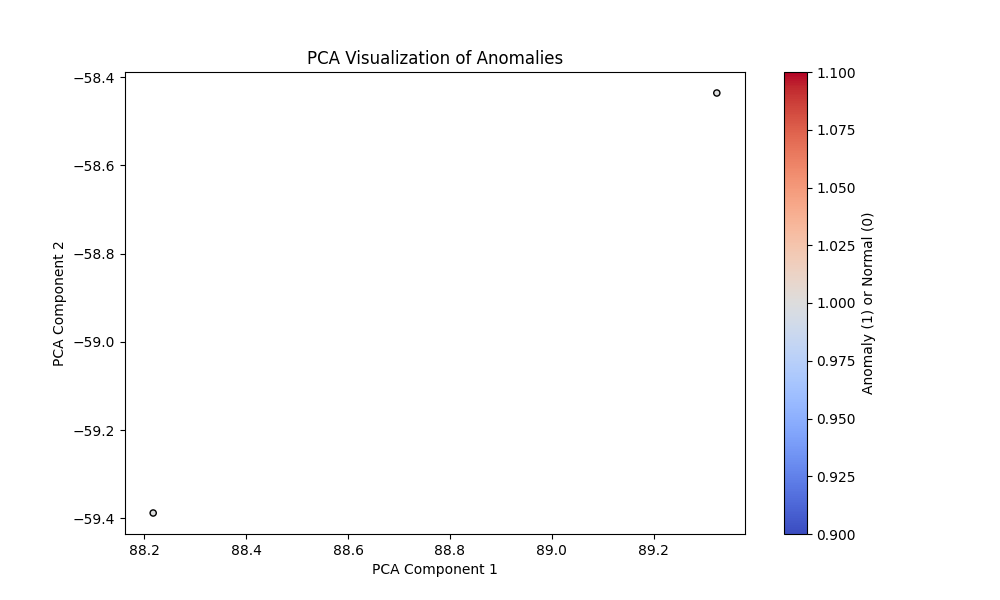

In [15]:
from IPython.display import Image, display
display(Image(data=base64.b64decode(pca_plot_base64)))
